## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt


In [3]:
from dask.distributed import performance_report

In [4]:
cluster = coiled.Cluster(
    name="pyarrow-dask-benchmarking",
    n_workers=10,
    package_sync=True,
)

Output()

Output()

In [6]:
file_paths = [
    f"s3://nyc-tlc/trip data/yellow_tripdata_{year}*.parquet"
    for year in (2021, 2022)
]
file_paths

['s3://nyc-tlc/trip data/yellow_tripdata_2021*.parquet',
 's3://nyc-tlc/trip data/yellow_tripdata_2022*.parquet']

In [7]:
ddf = dd.read_parquet(
    file_paths,
    columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
)

In [8]:
wait(ddf);

In [ ]:
ddf.head(3)

In [9]:
ddf

,VendorID,passenger_count,trip_distance,store_and_fwd_flag,total_amount
npartitions=24,,,,,
,int64,float64,float64,object,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [ ]:
wait(ddf);

In [10]:
ddf.dtypes

VendorID                int64
passenger_count       float64
trip_distance         float64
store_and_fwd_flag     object
total_amount          float64
dtype: object

In [ ]:
ddf.size.compute()

In [11]:
ddf = ddf.repartition(partition_size="100Mb").persist()

In [12]:
ddf.npartitions

76

In [ ]:
ddf.memory_usage_per_partition().compute()

## Create memory samplers and store benchmarks with object strings

In [13]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()
ms5 = MemorySampler()
ms6 = MemorySampler()

In [14]:
# 1
with performance_report(filename="1-cluster-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        %timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

776 ms ± 81.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [15]:
# 2
with performance_report(filename="2-cluster-object-group-sum.html"):
    with ms2.sample("object string", interval=0.1):
        %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").total_amount.sum().compute()

1.43 s ± 152 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [16]:
# 3
with performance_report(filename="3-cluster-object-group-mean.html"):
    with ms3.sample("object string", interval=0.05):
        %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.mean().compute()

2.08 s ± 61 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [17]:
# 4
with performance_report(filename="4-cluster-object-group-median.html"):
    with ms4.sample("object string"):
        %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.median().compute()

14.8 s ± 366 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [18]:
# 5
with performance_report(filename="5-cluster-object-strlen.html"):
    with ms5.sample("object string", interval=0.1):
        %timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

4.36 s ± 105 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [19]:
# 6
with performance_report(filename="6-cluster-object-group-sum2.html"):
    with ms6.sample("object string", interval=0.1):
        %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").passenger_count.sum().compute()

1.28 s ± 120 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Restart the client

In [ ]:
client.restart()

## Now store benchmarks with arrow strings, and plot the difference

In [21]:
with dask.config.set({"dataframe.convert_string": True}):
    ddf2 = dd.read_parquet(
        file_paths,
        columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
        split_row_groups=True,
    )

In [22]:
wait(ddf2);

In [23]:
ddf2 = ddf2.repartition(partition_size="100Mb").persist()

In [24]:
ddf2.npartitions

42

In [ ]:
ddf2.memory_usage_per_partition().compute()

In [25]:
ddf2.dtypes

VendorID                        int64
passenger_count               float64
trip_distance                 float64
store_and_fwd_flag    string[pyarrow]
total_amount                  float64
dtype: object

In [26]:
# 1, ddf2
with performance_report(filename="1-cluster-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

370 ms ± 32.2 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

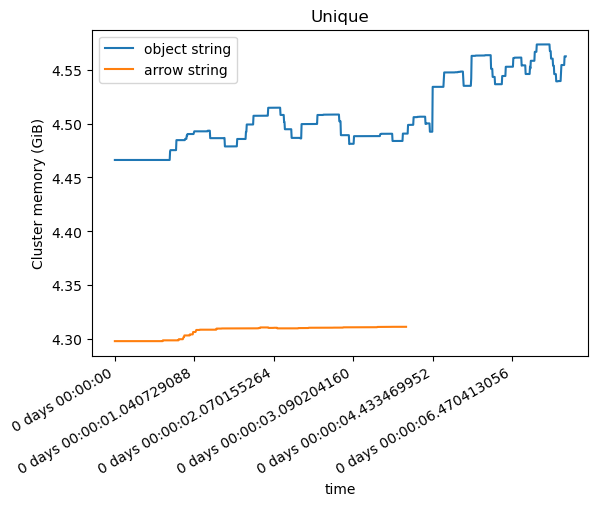

In [27]:
ms1.plot(align=True, title="Unique")

In [28]:
# 2, ddf2
with performance_report(filename="2-cluster-string-group-sum.html"):
    with ms2.sample("arrow string"):
        %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").total_amount.sum().compute()

679 ms ± 160 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum'}, xlabel='time', ylabel='Cluster memory (GiB)'>

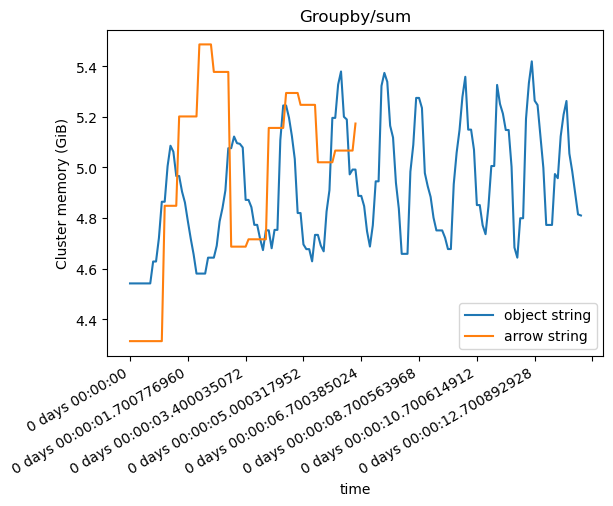

In [29]:
ms2.plot(align=True, title="Groupby/sum")

In [30]:
# 3, ddf2
with performance_report(filename="3-cluster-string-group-mean.html"):
    with ms3.sample("arrow string", interval=0.05):
        %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.mean().compute()

971 ms ± 73.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/mean'}, xlabel='time', ylabel='Cluster memory (GiB)'>

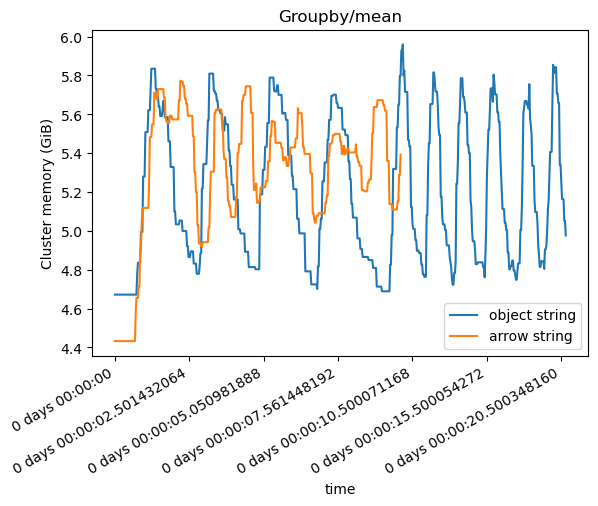

In [31]:
ms3.plot(align=True, title="Groupby/mean")

In [32]:
#4, ddf2
with performance_report(filename="4-cluster-string-group-median.html"):
    with ms4.sample("arrow string"):
        %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.median().compute()

18.6 s ± 503 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/median'}, xlabel='time', ylabel='Cluster memory (GiB)'>

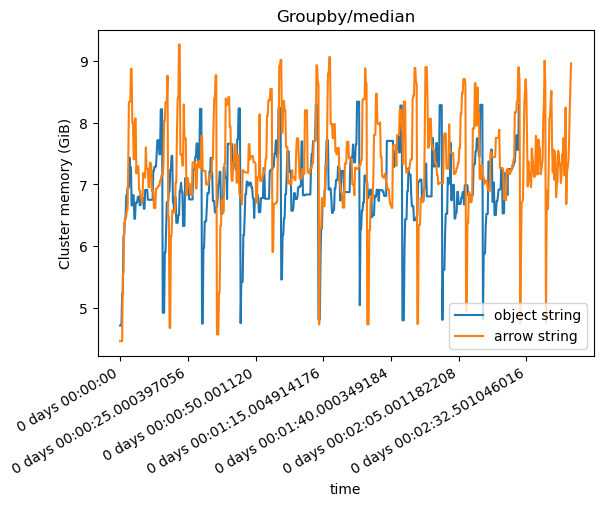

In [33]:
ms4.plot(align=True, title="Groupby/median")

In [34]:
# 5, ddf2
with performance_report(filename="5-cluster-string-strlen.html"):
    with ms5.sample("arrow string", interval=0.1):
        %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

2.28 s ± 609 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

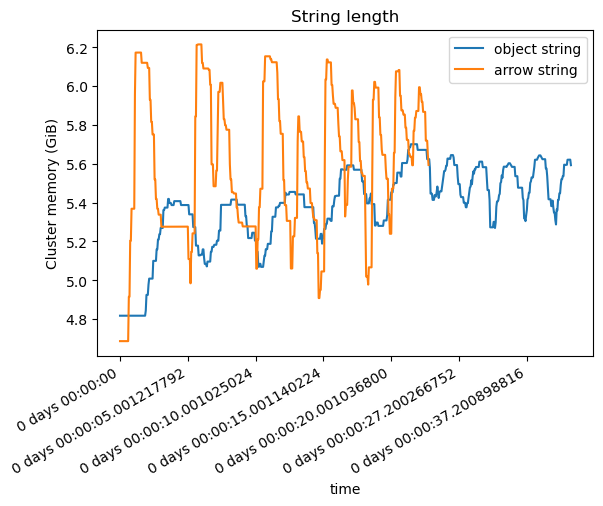

In [35]:
ms5.plot(align=True, title="String length")

In [36]:
#6, ddf2
with performance_report(filename="6-cluster-string-groupby-sum2.html"):
    with ms6.sample("arrow string", interval=0.1):
        %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").passenger_count.sum().compute()

632 ms ± 65.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum 2'}, xlabel='time', ylabel='Cluster memory (GiB)'>

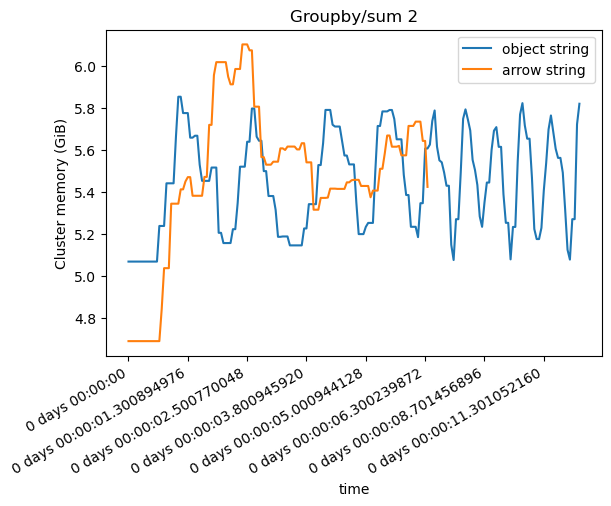

In [37]:
ms6.plot(align=True, title="Groupby/sum 2")

In [ ]:
client.restart()  # Release futures and clear up memory on the cluster

In [34]:
client.close()

In [35]:
cluster.close()